<a href="https://colab.research.google.com/github/sayalaruano/Project3Period-SysBioMaster/blob/main/Project1_SysBio_NF_HCM_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting cardiomyopathies using RNAseq data with machine learning models**

This notebook is part of a group project for the Systems Biology masters at Maastricht University.

You can find more details about my capstone project in this [GitHub repository](https://github.com/sayalaruano/Project3Period-SysBioMaster).

## Dataset description
We will be using an [RNA-sequencing dataset from the MAGNet consortium](https://github.com/mpmorley/MAGNet). To generate this dataset, leftventricular free-wall tissue was harvested at the time of cardiac surgery fromsubjects with heart failure undergoing transplantation and from unused donor hearts with apparently normal function.  This dataset is a spectacular resource of left ventricular transcriptomes of **non-failing healthy donors**, 
**Peripartum cardiomyopathy (PPCM)**, **Hypertrophic cardiomyopathy (HCM)** and **Dilated cardiomyopathy (DCM)** patients. Next to the RNA-sequencing data (in log2-transformed CPM values), extensive participant information is available (age, sex, ethnicity, disease state, and so on).

**Note:** `mkdir`, `wget`, `unzip`, `make`, `cd`, `grep`, and `cat` are Unix based OS commands, so if you are in Windows, maybe these terminal tools won't work.

## **Installation of libraries**

### **[LazyPredict](https://github.com/shankarpandala/lazypredict)**
Library to run many sklearn's binary classifiers with default parameters

In [1]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Imports, data obtention, and pre-processing**

In [2]:
# Download and unzip 
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Data manipulation and EDA
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning classifers
import lazypredict
import pickle
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_curve
from sklearn.metrics import make_scorer
from matplotlib_venn import venn3

In [3]:
# Download and unzip data
def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

url = "https://surfdrive.surf.nl/files/index.php/s/mZrXMDlQ1Z1LvTn/download"

download_and_unzip(url, extract_to='.')

## **Feature matrices preparation**


### **Load molecular descriptors (features)**

In [4]:
# Load gene expression and sampleinfo data 
gxData_cpm = pd.read_table("MAGNET_GeneExpressionData_CPM_19112020.txt", index_col=0)

sampleInfo = pd.read_csv("MAGNET_SampleData_18112022.csv")

In [5]:
# Transpose the gx dataframe
gxData_cpm = gxData_cpm.transpose()

# Create a new column with index values 
gxData_cpm = gxData_cpm.rename_axis('sample_name').reset_index()

# Rename the index name
gxData_cpm = gxData_cpm.rename_axis(None, axis=1)

In [6]:
# Get a df with the etiology and sample name columns 
columns = ["etiology", "sample_name"]

etiology = sampleInfo[columns]

In [7]:
# Join the etiology and gx dataframes
gxData_cpm_labeled = pd.merge(gxData_cpm, etiology, on='sample_name', how='inner')

In [8]:
# Prin the number of samples per etiology
gxData_cpm_labeled["etiology"].value_counts()

NF      166
DCM     166
HCM      28
PPCM      6
Name: etiology, dtype: int64

In [9]:
# Select the NF and DCM patients
gxData_cpm_lab_NFHCM = gxData_cpm_labeled[(gxData_cpm_labeled["etiology"] == "NF") | 
                                          (gxData_cpm_labeled["etiology"] == "HCM")]

In [10]:
# Create the y label dataset
y = gxData_cpm_lab_NFHCM['etiology'].copy()

# Encoding the target class label
y = y.map({"HCM": 1, "NF": 0}).to_numpy()

In [11]:
# Create the feature matrix by deleting the y column and the sample name
final_df_NFHCM = gxData_cpm_lab_NFHCM.drop(['etiology', 'sample_name'], axis=1)
X = final_df_NFHCM.to_numpy()

## **Exploratory Data Analysis**

### **Target variable**

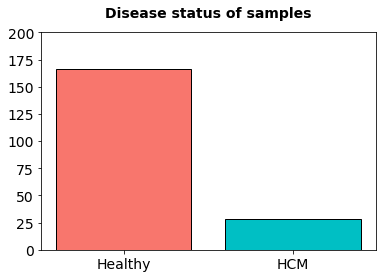

In [21]:
# Bar plot of active and inactive AMPs

# Data
n_healthy = (gxData_cpm_lab_NFHCM["etiology"] == "NF").sum()
n_disease = (gxData_cpm_lab_NFHCM["etiology"] == "HCM").sum()

x_label = ['Healthy', 'HCM']
y_label = [n_healthy, n_disease]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x_label, y_label, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('Disease status of samples', fontsize=14, fontweight='bold', pad=15)

ax.set_ylim(0,200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## **Machine learning models**
First, we tested more than 30 ML binary classifiers using the [LazyPredict](https://github.com/shankarpandala/lazypredict) Python library. We chose the best model evaluating some performance metrics (e.g., accuracy, ROC AUC, F1 score, and Matthews Correlation Coefficient) on the test dataset. 

In [22]:
# Run the ML classifiers with LazyPredict     
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state =42, 
                                                    stratify=y)

# Define and build the Lazyclassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=matthews_corrcoef)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [01:21<00:00,  2.80s/it]


In [23]:
# List of additional performance metrics
add_perf_metrics = [precision_score, recall_score]

# Loop by getting the performance metrics of all the ML models
for i in add_perf_metrics:

  clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric= i)

  new_models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  cols_to_use = new_models.columns.difference(models.columns)

  models = pd.merge(models, new_models[cols_to_use], left_index=True, right_index=True, how='outer')

100%|██████████| 29/29 [01:20<00:00,  2.78s/it]


In [24]:
# Delete Time column
models.drop(['Time Taken', 'ROC AUC'], axis=1, inplace=True)

In [25]:
models

,Accuracy,Balanced Accuracy,F1 Score,matthews_corrcoef,precision_score,recall_score
Model,,,,,,
LinearDiscriminantAnalysis,1.00,1.00,1.00,1.00,1.00,1.00
SGDClassifier,0.97,0.98,0.98,0.91,0.86,1.00
Perceptron,0.97,0.98,0.98,0.91,0.86,1.00
LinearSVC,0.95,0.97,0.95,0.84,0.75,1.00
PassiveAggressiveClassifier,0.95,0.97,0.95,0.84,0.75,1.00
RidgeClassifierCV,0.97,0.92,0.97,0.90,1.00,0.83
RidgeClassifier,0.97,0.92,0.97,0.90,1.00,0.83
LogisticRegression,0.97,0.92,0.97,0.90,1.00,0.83
LGBMClassifier,0.97,0.92,0.97,0.90,1.00,0.83


In [26]:
# Export results as a csv
models.to_csv("Results_allMLclassifiers_HCM.csv")

[(0.0, 1.0)]

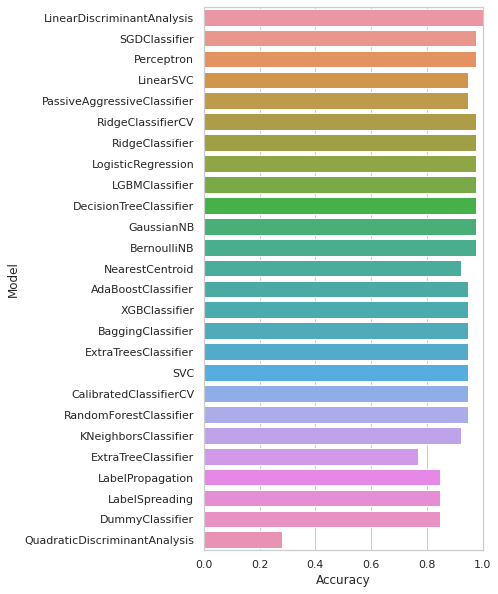

In [27]:
# Plot of Accuracy
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models.index, x="Accuracy", 
                 data=models)
ax.set(xlim=(0, 1))

[(0.0, 1.0)]

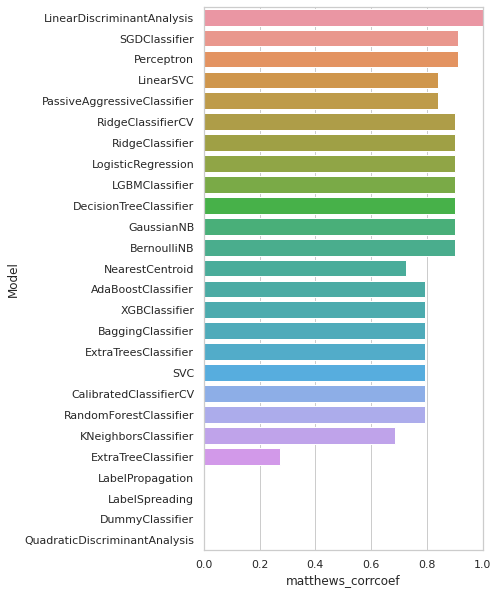

In [28]:
# Plot of MCC
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models.index, 
                 x="matthews_corrcoef", data=models)
ax.set(xlim=(0, 1))

---
We did not fine-tuned the hyperparameters of the best model because the performance metrics with the default parameters were very high, so hyperparameter tuning was not necessary.

### **Evaluation of the best model on the test dataset**
According to the summary tables presented above, there were some models with a perfect prediction capcity considering all of the performance metrics (values of 1 in the previous table). However, these methods are based on regression classifiers, which cannot show the feature importance of the model. So, we used the **RandomForestClassifier** that also have high performance metrics values and keep track of the feature importance (in this case, the gene expression values).

Thus, we trained this model again on the entire training dataset (without creating the validation partition) and evaluated it on the **test dataset**. 

In [29]:
# Implementation of the best models
best_model1 = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=42))
best_model1.fit(X_train, y_train)

best_model2 = make_pipeline(StandardScaler(), LGBMClassifier(random_state=42))
best_model2.fit(X_train, y_train)

best_model3 = make_pipeline(StandardScaler(), XGBClassifier(random_state=42))
best_model3.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier', XGBClassifier(random_state=42))])

In [30]:
models_names = [best_model1, best_model2, best_model3]

In [31]:
# Function to calculate performance metrics
def performance_metrics(y, y_pred):
  acc = accuracy_score(y, y_pred)

  bal_acc = balanced_accuracy_score(y, y_pred)

  prec = precision_score(y, y_pred)

  recall = recall_score(y, y_pred)

  f1score = f1_score(y, y_pred)

  mcc = matthews_corrcoef(y, y_pred)

  results = [acc, bal_acc, prec, recall, f1score, mcc]

  return results

In [32]:
# Dataset to store performance metrics of test dataset
results_bestMLmodels_test = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                                              'Recall', 'F1score', 'MCC'])
# Set indices
results_bestMLmodels_test.set_index(idxs, inplace=True)

In [33]:
for i in models_names:  
  # Predicting values with the best model on test and external datasets
  y_test_pred = i.predict(X_test)

  # Calculate performance metrics of test dataset
  results_bestMLmodels_test[type(i[1]).__name__] = performance_metrics(y_test, y_test_pred)

In [34]:
results_bestMLmodels_test

,DecisionTreeClassifier,LGBMClassifier,XGBClassifier
Accuracy,0.97,0.97,0.95
Balanced accuracy,0.92,0.92,0.83
Precision,1.00,1.00,1.00
Recall,0.83,0.83,0.67
F1score,0.91,0.91,0.80
MCC,0.90,0.90,0.79


In [35]:
# Export results as a csv
results_bestMLmodels_test.to_csv("Results_best_ensembleclassifiers_HCM_test_datatset.csv")

## ROC curves

<Figure size 432x288 with 0 Axes>

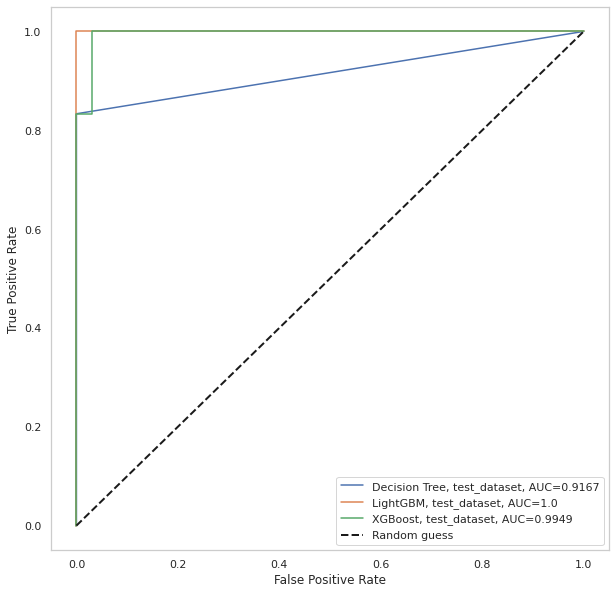

In [36]:
#set up plotting area
plt.figure(0).clf()
plt.figure(figsize=(10, 10))

#fit best model1 and plot ROC curve, test dataset
y_pred1 = best_model1.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred1)
auc1 = round(roc_auc_score(y_test, y_pred1), 4)
plt.plot(fpr,tpr,label="Decision Tree, test_dataset, AUC="+str(auc1))

#fit best model2 and plot ROC curve, test dataset
y_pred2 = best_model2.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred2)
auc2 = round(roc_auc_score(y_test, y_pred2), 4)
plt.plot(fpr,tpr,label="LightGBM, test_dataset, AUC="+str(auc2))

#fit best model3 and plot ROC curve, test dataset
y_pred3 = best_model3.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred3)
auc3 = round(roc_auc_score(y_test, y_pred3), 4)
plt.plot(fpr,tpr,label="XGBoost, test_dataset, AUC="+str(auc3))

# Add random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random guess')

#add legend and titles
#plt.title('ROC curve')
plt.grid(None)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('ROC_curve_DCM_bestmodels.png', bbox_inches='tight')
plt.savefig('ROC_curve_DCM_bestmodels.svg', bbox_inches='tight')

### **Feature importance of the best model**

In [37]:
# Retrieve feature importance from the best models
importance_bestmodel1 = pd.Series(best_model1[1].feature_importances_, name = 'Gini')
importance_bestmodel2 = pd.Series(best_model2[1].feature_importances_, name = 'Importance (split)')
importance_bestmodel3 = pd.Series(best_model3[1].feature_importances_, name = 'Importance (weight)')

# Retrieve feature names
feature_names = pd.Series(final_df_NFHCM.columns, name = 'Feature')

In [38]:
# Combine feature names and Gini values into a Dataframe
feat_import_bestmodel1 = pd.concat([feature_names, importance_bestmodel1], axis=1, names=['Feature', 'Gini'])
feat_import_bestmodel2 = pd.concat([feature_names, importance_bestmodel2], axis=1, names=['Feature', 'Importance (split)'])
feat_import_bestmodel3 = pd.concat([feature_names, importance_bestmodel3], axis=1, names=['Feature', 'Importance (weight)'])

# Sort the dataframe by Gini in descending order
featimp_bestmodel1_sort = feat_import_bestmodel1.sort_values('Gini', ascending=False)
featimp_bestmodel2_sort = feat_import_bestmodel2.sort_values('Importance (split)', ascending=False)
featimp_bestmodel3_sort = feat_import_bestmodel3.sort_values('Importance (weight)', ascending=False)

In [39]:
# Export sorted feature importance datasets
featimp_bestmodel1_sort.to_csv("Important_genes_HCM_DecisionTree_sorted.csv")
featimp_bestmodel2_sort.to_csv("Important_genes_HCM_LGBM_sorted.csv")
featimp_bestmodel3_sort.to_csv("Important_genes_HCM_XGBoost_sorted.csv")

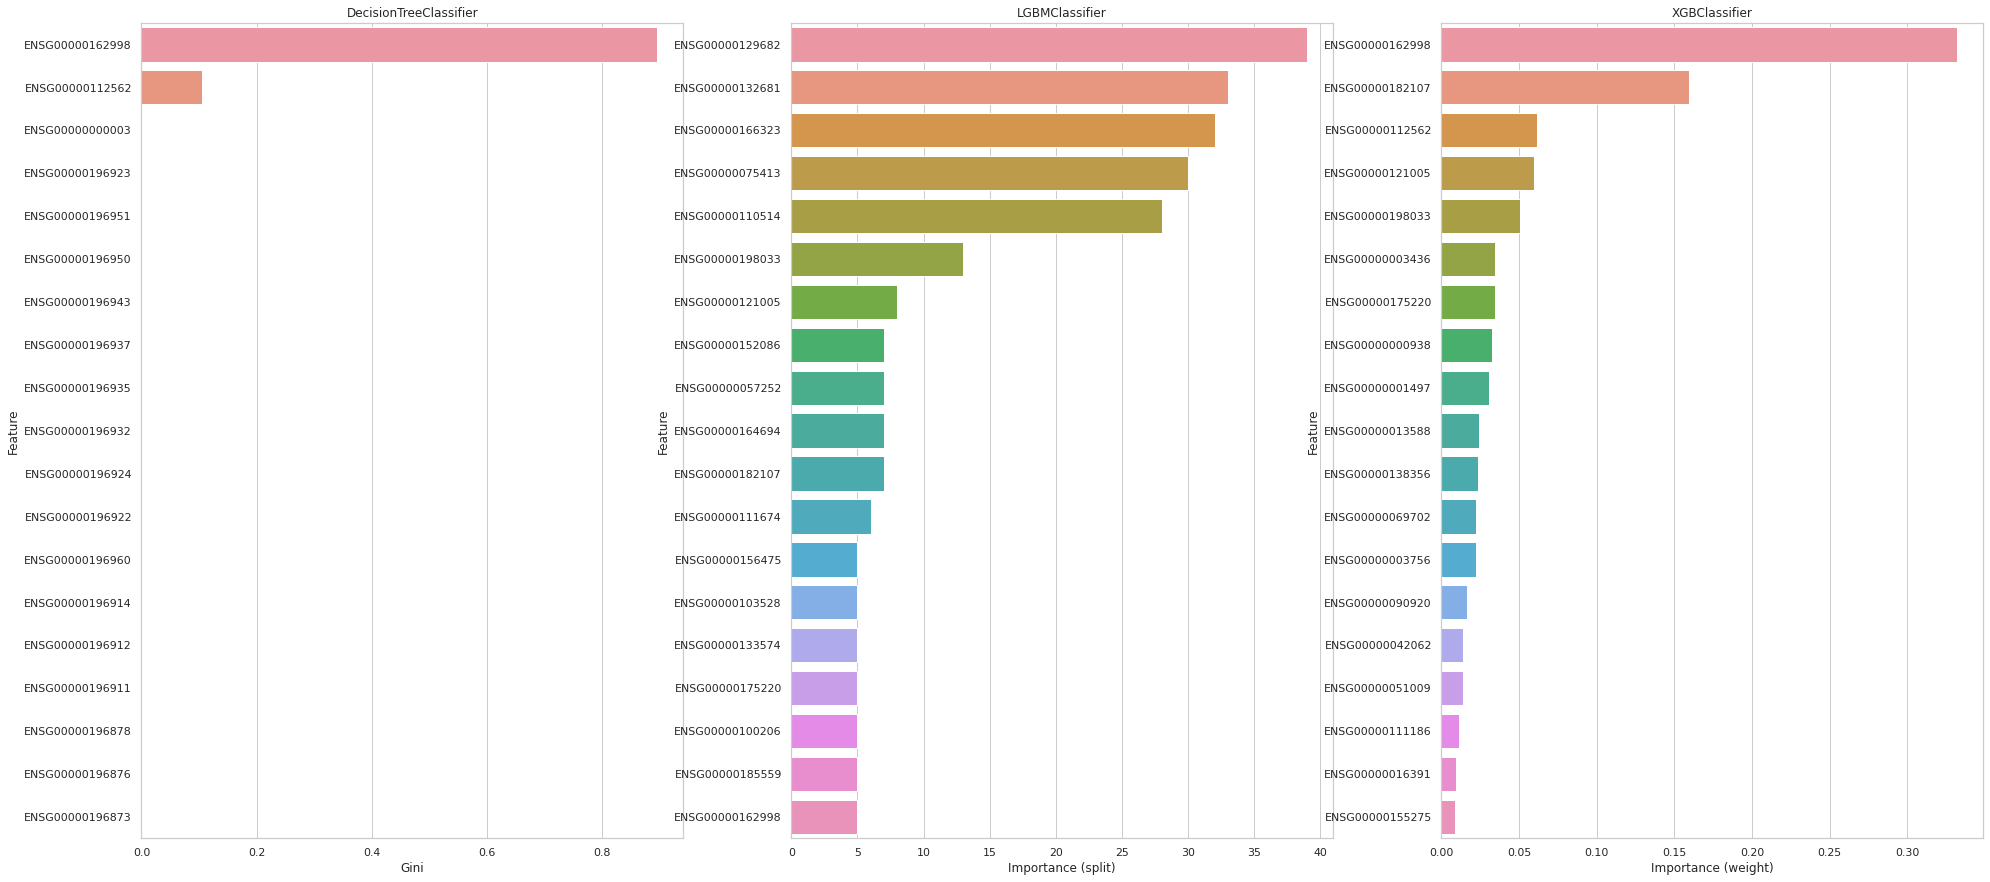

In [40]:
# Plot of feature importance of the 3 algorithms
#plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(33, 15))

sns.barplot(ax = ax1, x = 'Gini', y = 'Feature', data = featimp_bestmodel1_sort.iloc[0:19])
ax1.title.set_text('DecisionTreeClassifier')
sns.barplot(ax = ax2, x = 'Importance (split)', y = 'Feature', data = featimp_bestmodel2_sort.iloc[0:19])
ax2.title.set_text('LGBMClassifier')
sns.barplot(ax = ax3, x = 'Importance (weight)', y = 'Feature', data = featimp_bestmodel3_sort.iloc[0:19])
ax3.title.set_text('XGBClassifier')

The feature importance results show that most of the genes have low Gini impurity values, which means that all elements belong to a certain class and there are not highly important genes that helps to the classification task.

In [57]:
# Get the top 500 most important genes for each method
imp_genes_DT = featimp_bestmodel1_sort.iloc[0:500]
imp_genes_LGBM = featimp_bestmodel2_sort.iloc[0:500]
imp_genes_XGB = featimp_bestmodel3_sort.iloc[0:500]

In [58]:
# Obtain the top 50 most important genes that are present in at least two methods
consensus_genes1 = imp_genes_DT.merge(imp_genes_LGBM,on='Feature')
consensus_genes2 = imp_genes_DT.merge(imp_genes_XGB,on='Feature')
consensus_genes3 = imp_genes_XGB.merge(imp_genes_LGBM,on='Feature')

In [59]:
# Concatenate the results
df_final = pd.concat([consensus_genes1, consensus_genes2, consensus_genes3], axis=0, ignore_index=True)

In [60]:
# Remove duplicates 
df_final.drop_duplicates("Feature", inplace=True)

In [61]:
df_final

,Feature,Gini,Importance (split),Importance (weight)
0,ENSG00000162998,0.90,5.00,NaN
1,ENSG00000197006,0.00,0.00,NaN
2,ENSG00000197019,0.00,0.00,NaN
3,ENSG00000197016,0.00,0.00,NaN
4,ENSG00000197013,0.00,0.00,NaN
...,...,...,...,...
310,ENSG00000182107,NaN,7.00,0.16
311,ENSG00000121005,NaN,8.00,0.06
312,ENSG00000198033,NaN,13.00,0.05
313,ENSG00000175220,NaN,5.00,0.03


In [54]:
# Export consensus genes
df_final.to_csv("Consensus3methods_500important_genes_HCM.csv")

## Ven diagram

In [62]:
imp_genes_DT_set = set(imp_genes_DT['Feature'])
imp_genes_XGB_set = set(imp_genes_XGB['Feature'])
imp_genes_LGBM_set = set(imp_genes_LGBM['Feature'])

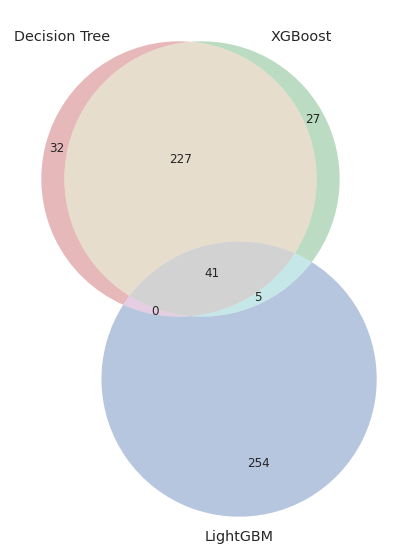

In [63]:
# Create Ven diagram
plt.figure(figsize=(10, 10))
venn3([imp_genes_DT_set, imp_genes_XGB_set, imp_genes_LGBM_set], ('Decision Tree', 'XGBoost', 'LightGBM'))

# Save the plot
plt.savefig('Ven_diagram_HCM_bestmodels.svg', bbox_inches='tight')
plt.savefig('Ven_diagram_HCM_bestmodels.png', bbox_inches='tight')

### **Save the best model into a file**

In [ ]:
# Define the output file's name
output_file = f'RandomForestClassifier_NF_DCM'
output_file

In [ ]:
# Export the binary file of the best model
#with open(output_file, "wb") as f_out:
 #   pickle.dump(best_model[1], f_out)

---